# DS-7331 Machine Learning Project 3
## Airbnb Clustering Tasks
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

https://nbviewer.jupyter.org/github/allenmiller17/SMU_7331_ML1_Projects/blob/main/Project_2_Final_Team.ipynb

In [1]:
#loading libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np
from scipy import stats

from sklearn import metrics as mt

from sklearn.cluster import KMeans

In [2]:
pdata = pd.read_csv("airbnb1.csv")

In [3]:
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30739 entries, 0 to 30738
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      30739 non-null  int64  
 1   log_price               30739 non-null  float64
 2   property_type           30739 non-null  object 
 3   room_type               30739 non-null  object 
 4   accommodates            30739 non-null  int64  
 5   bathrooms               30645 non-null  float64
 6   bed_type                30739 non-null  object 
 7   cancellation_policy     30739 non-null  object 
 8   cleaning_fee            30739 non-null  bool   
 9   city                    30739 non-null  object 
 10  description             30739 non-null  object 
 11  first_review            24150 non-null  object 
 12  host_has_profile_pic    30648 non-null  object 
 13  host_identity_verified  30648 non-null  object 
 14  host_response_rate      23119 non-null

In [4]:
pdata.nunique()

id                        30739
log_price                   614
property_type                31
room_type                     3
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               30615
first_review               2234
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           76
host_since                 2902
instant_bookable              2
last_review                1132
latitude                  30731
longitude                 30713
neighbourhood               571
number_of_reviews           314
review_scores_rating         48
zipcode                     606
bedrooms                     11
beds                         17
dtype: int64

In [5]:
#transforming the property type to a binary classification
value_list = ["Apartment","House","Condominium","Townhouse","Loft"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"

#transforming the longitude and latitude variables to East / West
pdata["region"] = pd.cut(pdata.longitude,[-200,-100,0],2,labels=["West","East"])

In [6]:
#evaluating the data after transformation
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
0,6901257,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,...,7/18/2016,40.696524,-73.991617,Brooklyn Heights,2,100.0,11201,1.0,1.0,East
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,...,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,...,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
3,13418779,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,...,NaN,37.772004,-122.431619,Lower Haight,0,NaN,94117,2.0,2.0,West
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,...,1/22/2017,38.925627,-77.034596,Columbia Heights,4,40.0,20009,0.0,1.0,East


In [7]:
#Encoding boolean and categorical variables
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 0,"House": 1,"Condominium": 2,"Townhouse": 3,"Loft": 4, "other": 5},
                "region": {"East": 0, "West": 1},
                "room_type": {"Entire home/apt": 0, "Private room": 1, "Shared room": 2},
                "bed_type": {"Real Bed": 0, "Futon": 1, "Pull-out Sofa": 2, "Couch": 3, "Airbed": 4},
                "city": {"NYC": 0, "SF": 1, "DC": 2, "LA": 3, "Chicago": 4, "Boston": 5},
                "cancellation_policy": {"strict": 0, "moderate": 1, "flexible": 2, "super_strict_30": 3, "super_strict_60": 4}
                    }

pdata=pdata.replace(replaceStruct)

In [8]:
pdata.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','latitude','longitude','neighbourhood','host_has_profile_pic'], axis=1, inplace=True)


In [9]:
#evaluating the data after transformation
pdata.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,region
0,5.010635,0,0,3,1.0,0,0,1,0,1.0,0,2,100.0,1.0,1.0,0
1,5.129899,0,0,7,1.0,0,0,1,0,0.0,1,6,93.0,3.0,3.0,0
2,4.976734,0,0,5,1.0,0,1,1,0,1.0,1,10,92.0,1.0,3.0,0
3,6.620073,1,0,4,1.0,0,2,1,1,1.0,0,0,NaN,2.0,2.0,1
4,4.744932,0,0,2,1.0,0,1,1,2,1.0,1,4,40.0,0.0,1.0,0


In [10]:
pdata.nunique()

log_price                 614
property_type               6
room_type                   3
accommodates               16
bathrooms                  17
bed_type                    5
cancellation_policy         5
cleaning_fee                2
city                        6
host_identity_verified      2
instant_bookable            2
number_of_reviews         314
review_scores_rating       48
bedrooms                   11
beds                       17
region                      2
dtype: int64

In [11]:
pdata = pdata.dropna()

In [12]:
#Scale the data and deploy model

from scipy.stats import zscore

pdata_z = pdata.apply(zscore)

Text(0.5, 1.0, 'K Optimization Graph')

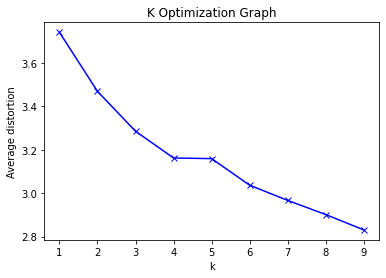

In [13]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(pdata_z)
    prediction=model.predict(pdata_z)
    meanDistortions.append(sum(np.min(cdist(pdata_z, model.cluster_centers_, 'euclidean'), axis=1)) / pdata_z
                           .shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('K Optimization Graph')

In [14]:
KNNModel = KMeans(n_clusters=5, n_init = 3, random_state=2345)
KNNModel.fit(pdata_z)
prediction=KNNModel.predict(pdata_z)
pdata_z["GROUP"] = prediction
pdata_z["GROUP"] = prediction

In [15]:
#Assess the distribution of clusters formed
pdata_z['GROUP'].value_counts()  

1    7166
2    6618
3    4378
0    4292
4    1158
Name: GROUP, dtype: int64

In [16]:
pdata_z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23612 entries, 0 to 30735
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               23612 non-null  float64
 1   property_type           23612 non-null  float64
 2   room_type               23612 non-null  float64
 3   accommodates            23612 non-null  float64
 4   bathrooms               23612 non-null  float64
 5   bed_type                23612 non-null  float64
 6   cancellation_policy     23612 non-null  float64
 7   cleaning_fee            23612 non-null  float64
 8   city                    23612 non-null  float64
 9   host_identity_verified  23612 non-null  float64
 10  instant_bookable        23612 non-null  float64
 11  number_of_reviews       23612 non-null  float64
 12  review_scores_rating    23612 non-null  float64
 13  bedrooms                23612 non-null  float64
 14  beds                    23612 non-null

In [17]:
pdata_z.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,region,GROUP
0,0.387552,-0.52957,-0.824389,-0.105514,-0.404827,-0.150378,-0.922086,0.507968,-0.987322,0.614423,-0.609389,-0.606959,0.750159,-0.305526,-0.579590,-0.802605,1
1,0.564606,-0.52957,-0.824389,1.733502,-0.404827,-0.150378,-0.922086,0.507968,-0.987322,-1.627543,1.640987,-0.510226,-0.138972,2.061295,0.984264,-0.802605,0
2,0.337224,-0.52957,-0.824389,0.813994,-0.404827,-0.150378,0.317370,0.507968,-0.987322,0.614423,1.640987,-0.413494,-0.265991,-0.305526,0.984264,-0.802605,1
4,-0.006900,-0.52957,-0.824389,-0.565268,-0.404827,-0.150378,0.317370,0.507968,0.245858,0.614423,1.640987,-0.558592,-6.870965,-1.488936,-0.579590,-0.802605,1
5,-0.455654,-0.52957,1.003870,-0.565268,-0.404827,-0.150378,-0.922086,0.507968,-0.370732,0.614423,1.640987,-0.582776,0.750159,-0.305526,-0.579590,1.245943,2


In [18]:
pdata_z.nunique()

log_price                 542
property_type               6
room_type                   3
accommodates               16
bathrooms                  16
bed_type                    5
cancellation_policy         5
cleaning_fee                2
city                        6
host_identity_verified      2
instant_bookable            2
number_of_reviews         313
review_scores_rating       48
bedrooms                   11
beds                       16
region                      2
GROUP                       5
dtype: int64

<Figure size 360x360 with 0 Axes>

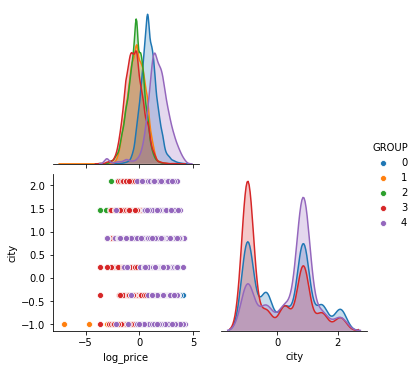

In [19]:
#https://seaborn.pydata.org/generated/seaborn.pairplot.html

plt.figure(figsize=(5,5))
sns.pairplot(pdata_z,vars=pdata_z[['log_price','city']], hue = "GROUP" ,diag_kind = 'kde', corner = True)
plt.show()

Text(0.5, 0.92, '3D plot of KMeans Clustering')

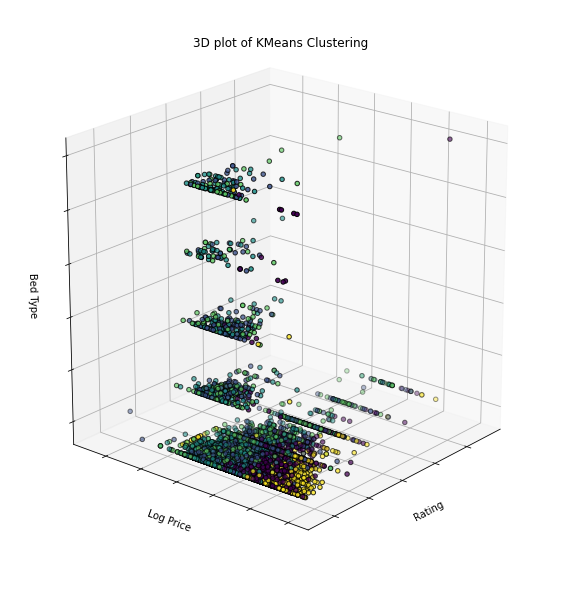

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=40)
labels = KNNModel.labels_
ax.scatter(pdata_z.iloc[:, 12], pdata_z.iloc[:,0], pdata_z.iloc[:,5],c=labels.astype(np.float), edgecolor='k')
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Rating')
ax.set_ylabel('Log Price')
ax.set_zlabel('Bed Type')
ax.set_title('3D plot of KMeans Clustering')

array([[<AxesSubplot:title={'center':'accommodates'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'bathrooms'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'bed_type'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'bedrooms'}, xlabel='[GROUP]'>],
       [<AxesSubplot:title={'center':'beds'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'cancellation_policy'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'city'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'cleaning_fee'}, xlabel='[GROUP]'>],
       [<AxesSubplot:title={'center':'host_identity_verified'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'instant_bookable'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'log_price'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'number_of_reviews'}, xlabel='[GROUP]'>],
       [<AxesSubplot:title={'center':'property_type'}, xlabel='[GROUP]'>,
        <AxesSubplot:title={'center':'region'}, xla

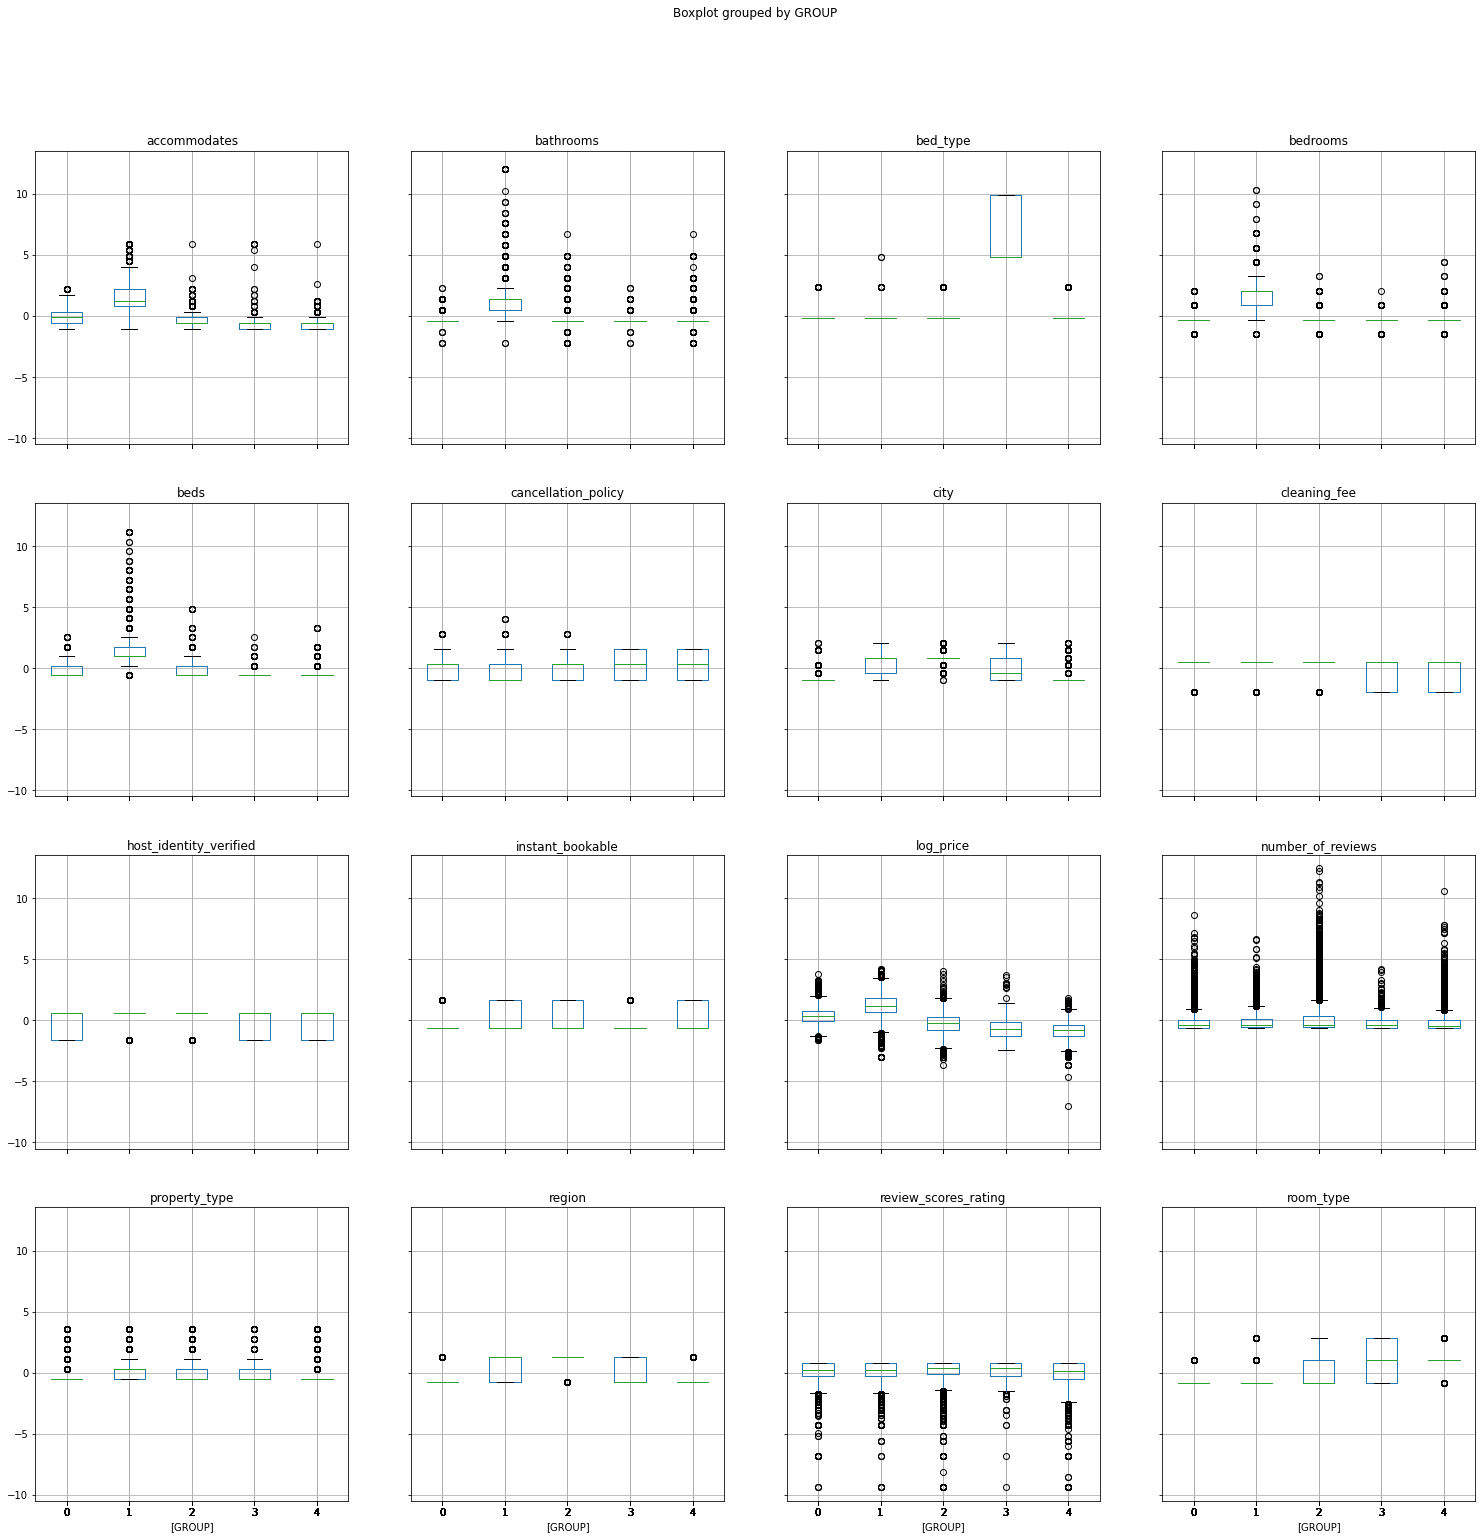

In [51]:
pdata_z.boxplot(by="GROUP", figsize=(25, 25))

In [55]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [56]:
# cophenet index 
Z = linkage(pdata_z, metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(pdata_z))

c

0.7808061280647195

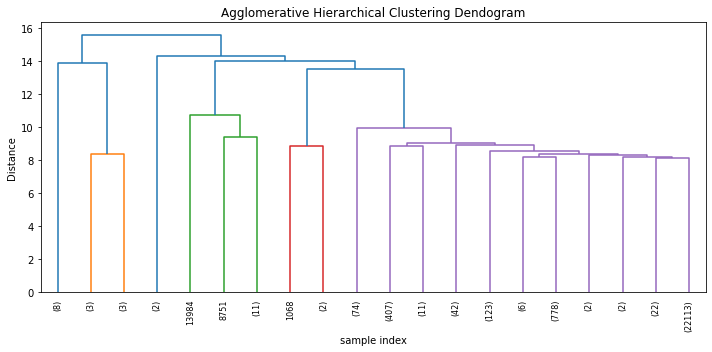

In [59]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()

In [61]:
# cophenet index 
Z1 = linkage(pdata_z, metric='euclidean', method='ward')
c1, coph_dists1 = cophenet(Z1 , pdist(pdata_z))

c1

0.42030794890888257

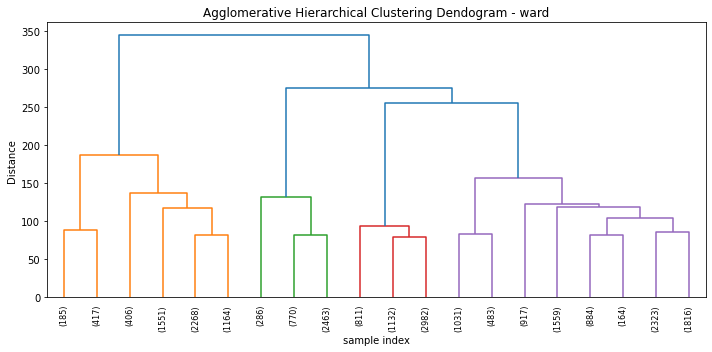

In [62]:
plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - ward')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z1, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()

In [63]:
# cophenet index 
Z2 = linkage(pdata_z, metric='euclidean', method='complete')
c2, coph_dists2 = cophenet(Z2 , pdist(pdata_z))

c2



0.6392776896808978

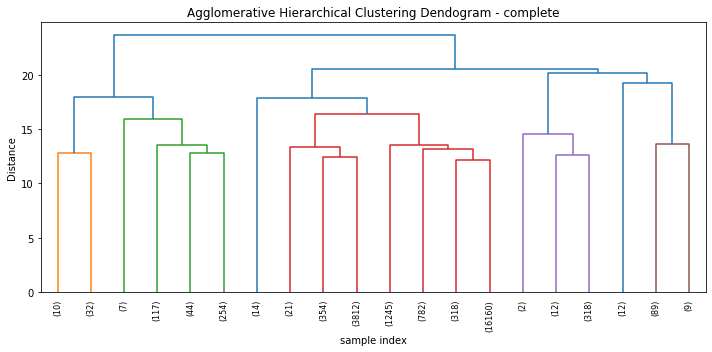

In [64]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - complete')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z2, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()


In [65]:
# cophenet index 
Z3 = linkage(pdata_z, metric='euclidean', method='centroid')
c3, coph_dists3 = cophenet(Z3 , pdist(pdata_z))

c3



0.7648900219947908

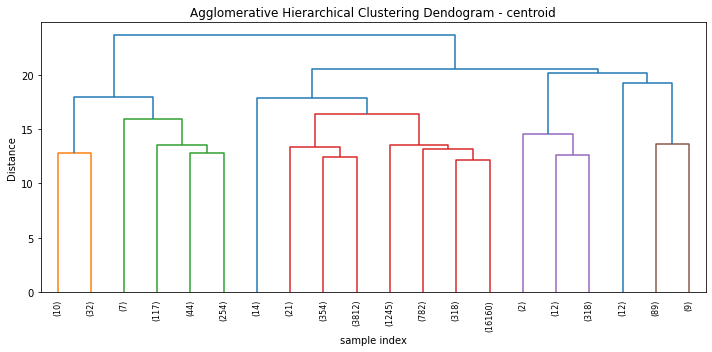

In [66]:

plt.figure(figsize=(10, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram - centroid')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z2, leaf_rotation=90., leaf_font_size=8. , truncate_mode = 'lastp',p=20)
plt.tight_layout()


In [ ]:
#evaluating categorical value count for one-hot-encoding
pdata_cls.nunique()

In [ ]:
#one hot encoding categorical variables and dropping columns that are not used
oneHotCols=["room_type","bed_type","city","cancellation_policy","region"]
pdata_cls.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','latitude','longitude','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata_cls=pd.get_dummies(pdata_cls, columns=oneHotCols,drop_first=True)
pdata_cls.head(10)

In [ ]:
# Creating the X and y variables for the Classification Model
X_cls = pdata_cls.drop('property_type',axis=1).values     
y_cls = pdata_cls['property_type'].values

#Scaling the Classification input
yhat_cls = np.zeros(y_cls.shape) # we will fill this with predictions
scl_cls = StandardScaler()
X_scaled_cls = scl_cls.fit_transform(X_cls)

In [ ]:
#Describe the final dataset
pdata_cls.info()

#### 1.3 Data Preparation for Regression Models

In [ ]:
#imputing missing numerical data by using the median, removing records with missing categorical values
pdata_reg = pdata.fillna(pdata.median())
pdata_reg = pdata_reg.dropna()

In [ ]:
# evaluating data after imputing with median
pdata_reg.skew()

To help our model we encoded all of the boolean features that were originally stored as character fields to reflect actual boolean type variables and reflected true values with a 1 and false values with a 0.

In [ ]:
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                    }
pdata_reg=pdata_reg.replace(replaceStruct)
pdata_reg.head()

We proceeded to one hot encode the categorical variables that we were going to leave in our models. This created a reference variable (0) and allows us to interpret the coefficients of the variables easier.

Unlike our classification task, we did not make property_type a binary attribute, instead we allow all distinct property_types to be one hot encoded and incorporated in the model.

In [ ]:
#one hot encoding categorical variables and dropping columns that are not used
oneHotCols=["room_type","bed_type","city","cancellation_policy", "property_type"]
pdata_reg.drop(['description','host_response_rate','first_review','host_since', 'zipcode','last_review','id','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata_reg=pd.get_dummies(pdata_reg, columns=oneHotCols,drop_first=True)
pdata_reg.head(10)

In [ ]:
# create regression x and y 
X_reg = pdata_reg.drop('log_price',axis=1).values     
y_reg = pdata_reg['log_price'].values

#Scaling the x
yhat_reg = np.zeros(y_reg.shape) # we will fill this with predictions
scl_reg = StandardScaler()
X_scaled_reg = scl_reg.fit_transform(X_reg)

In [ ]:
#Describing the final dataset for regression
pdata_reg.info()

### 2. Modeling and Evaluation

#### 2.1 Evaluation Metrics (Model and Evaluation 1)

#### 2.3 Classification Models (Model and Evaluation 3 Pt. 1) - Random Forest, KNN, Logistic Regression

For each model we performed a Grid Search and/or Random Search to optimize the hyperparameters.

##### 2.3.2 K-Nearest Neighbors Classification

In [ ]:
get_ipython().run_line_magic('time', '')
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline


#pipe = make_pipeline(('scale', StandardScaler()),  ('knn', KNeighborsClassifier()))

pipe = Pipeline([('scale', StandardScaler()),  
                         ('knn', KNeighborsClassifier())]) 

# Define a range of hyper parameters for grid search
parameters = { 'knn__n_neighbors': [10,45,50]
              , 'knn__algorithm' : ["auto", "ball_tree", "kd_tree", "brute"]
             }

#Perform the grid search using accuracy as a metric during cross validation.
gridKnn = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy') # can try f1_micro, f1_maco accuracy....

#Use the best features from recursive feature elimination during the grid search
gridKnn.fit(X_train_scaled_cls, y_train_cls)

#display the best pipeline model identified during the grid search
gridKnn.best_estimator_

In [ ]:
gridKnn.best_params_

In [ ]:
KNNmodelFINAL = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 45) # get object
KNNmodelFINAL.fit(X_train_scaled_cls, y_train_cls)
KNNy_hat = KNNmodelFINAL.predict(X_test_scaled_cls)

In [ ]:
from sklearn.model_selection import cross_val_score
KNNaccuracies = cross_val_score(KNNmodelFINAL, X_scaled_cls, y=y_cls, cv=cv) # this also can help with parallelism
print(KNNaccuracies)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print("Training accuracy",round(KNNmodelFINAL.score(X_train_scaled_cls,y_train_cls),ndigits=3))
print()
print("Testing accuracy",round(mt.accuracy_score(y_test_cls, KNNy_hat),ndigits=3))
print()
print('Confusion Matrix')
print(draw_cm(y_test_cls,KNNy_hat))

print(classification_report(y_test_cls,KNNy_hat))

In [ ]:
KNN_ac = round(mt.accuracy_score(y_test_cls, KNNy_hat),ndigits=3)

print(KNN_ac)